# Forecasting of Exports Data

## Visualisation of Data

### Data Preparation

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression


df = pd.read_csv('data/Handel.csv', sep=';',)
df_exchange = pd.read_csv('data/exchange.csv', sep=',')
df_BIP = pd.read_csv('data/BIP_Quartal.csv', sep=';')
df_DAX = pd.read_csv('data/DAX.csv', sep=';', dtype={'Datum': str})


# Map German month names to their respective numbers
month_mapping = {
    'Januar': 1, 'Februar': 2, 'März': 3, 'April': 4, 'Mai': 5, 'Juni': 6,
    'Juli': 7, 'August': 8, 'September': 9, 'Oktober': 10, 'November': 11, 'Dezember': 12
}

# Add a new column 'Date' by combining 'Jahr' and 'Monat'
df['Date'] = pd.to_datetime(df['Jahr'].astype(str) + '-' + df['Monat'].map(month_mapping).astype(str) + '-01')

# Rename columns for clarity
df.rename(columns={'Ausfuhr: Wert Tsd. EUR': 'value_Outgoing'}, inplace=True)

#Delete unnecessary columns
df.drop(columns=['Jahr', 'Monat', 'Land', 'Ausfuhr: Gewicht in t', 't', 'Veränderung zum Vorjahresmonat (%)', 'Veränderung zum Vorjahresmonat (%).1', 'Veränderung zum Vorjahresmonat (%).2', 'Veränderung zum Vorjahresmonat (%).3', 'Veränderung zum Vorjahresmonat (%).4', 'Veränderung zum Vorjahresmonat (%).5', 'Veränderung zum Vorjahresmonat (%).6', 'Veränderung zum Vorjahresmonat (%).7', 'Veränderung zum Vorjahresmonat (%).8', 'Veränderung zum Vorjahresmonat (%).9', 'Veränderung zum Vorjahresmonat (%).10', 'Veränderung zum Vorjahresmonat (%).11', 'Tsd. EUR','Tsd. EUR.1', 'Tsd. US $', 'Tsd. US $.1', 't.1'], inplace=True)

# Kausalvariable Exchange Rate
df_exchange['Period\\Unit:'] = pd.to_datetime(df_exchange['Period\\Unit:'])
df_exchange['[US dollar ]'] = pd.to_numeric(df_exchange['[US dollar ]'], errors='coerce')
df_exchange['YearMonth'] = df_exchange['Period\\Unit:'].dt.to_period('M').dt.to_timestamp()
monthly_avg = df_exchange.groupby('YearMonth', as_index=False)['[US dollar ]'].mean()
monthly_avg.rename(columns={'[US dollar ]': 'Monthly_Avg_Exchange_Rate'}, inplace=True)
df['Date'] = pd.to_datetime(df['Date'])
df['YearMonth'] = df['Date'].dt.to_period('M').dt.to_timestamp()
df = pd.merge(df, monthly_avg, on='YearMonth', how='left')
df.drop(columns=['YearMonth'], inplace=True)

# Kausalvariable BIP
# Expand df_BIP to have 3 rows per quarter (one for each month in the quarter)
df_BIP_expanded = pd.DataFrame({
    'Date': pd.date_range(start=f"{df_BIP['Jahr'].min()}-01-01", 
                          end=f"{df_BIP['Jahr'].max()}-12-31", 
                          freq='MS')
})
df_BIP_expanded['Jahr'] = df_BIP_expanded['Date'].dt.year
df_BIP_expanded['Quartal'] = ((df_BIP_expanded['Date'].dt.month - 1) // 3 + 1).astype(str) + '. Quartal'

# Merge the expanded DataFrame with df_BIP to assign BIP values to each month
df_BIP_expanded = pd.merge(df_BIP_expanded, df_BIP, on=['Jahr', 'Quartal'], how='left')

# Convert the BIP column to numeric, handling non-numeric values
df_BIP_expanded['BIP Mrd. EUR'] = df_BIP_expanded['BIP Mrd. EUR'].str.replace(',', '.').astype(float)

# Merge the BIP data into the main DataFrame
df = pd.merge(df, df_BIP_expanded[['Date', 'BIP Mrd. EUR']], on='Date', how='left')


# Kausalvariable DAX
# Convert the DAX column to float with 2 decimal places
df_DAX['DAX'] = df_DAX['DAX'].round(2)



# Convert the 'Date' column in df_DAX to datetime64[ns]
# Ensure the 'Datum' column contains valid date strings
# Convert 'Datum' column to datetime format
df_DAX['Date'] = pd.to_datetime(df_DAX['Datum'].astype(str), format='%m.%Y', errors='coerce')
# Manually add the first 12 Dates
# df_DAX.loc[:11, 'Date'] = pd.to_datetime([
#     '2000-01-01', '2000-02-01', '2000-03-01', '2000-04-01',
#     '2000-05-01', '2000-06-01', '2000-07-01', '2000-08-01',
#     '2000-09-01', '2000-10-01', '2000-11-01', '2000-12-01'
# ])

# Merge the DAX data into the main DataFrame
df = pd.merge(df, df_DAX[['Date', 'DAX']], on='Date', how='left')


df['Monate_seit_start'] = (df['Date'].dt.year - df['Date'].dt.year.min()) * 12 + df['Date'].dt.month - df['Date'].dt.month.min()


df

,value_Outgoing,Ausfuhr Wert Tsd. US $,Einfuhr: Gewicht t,Einfuhr Weert Tsd. EUR,Einfuhr: Wert Tsd. US $,Date,Monthly_Avg_Exchange_Rate,BIP Mrd. EUR,DAX,Monate_seit_start
0,4040020,-,"858430,8",3250132,-,2000-01-01,1.013695,519.98,153041.53,0
1,4948739,-,"622114,1",3255753,-,2000-02-01,0.983424,519.98,171153.03,1
2,5606604,-,"918986,9",4270195,-,2000-03-01,0.964343,519.98,170141.95,2
3,4344320,-,606669,3588842,-,2000-04-01,0.946950,524.39,166006.49,3
4,5586358,-,"641981,3",4305312,-,2000-05-01,0.905968,524.39,159177.66,4
...,...,...,...,...,...,...,...,...,...,...
295,12645859,13925620,"3040912,5",7900486,8700016,2024-08-01,1.101218,1078.22,423305.05,295
296,14605935,16221352,"2876726,8",7556107,8391813,2024-09-01,1.110600,1078.22,432663.83,296
297,13360210,14567973,"3518555,2",7819621,8526514,2024-10-01,1.090435,1101.42,427125.04,297
298,14320863,15223077,"2921921,6",7369423,7833697,2024-11-01,1.063014,1101.42,439414.53,298


### Visualisation of Causal Variables

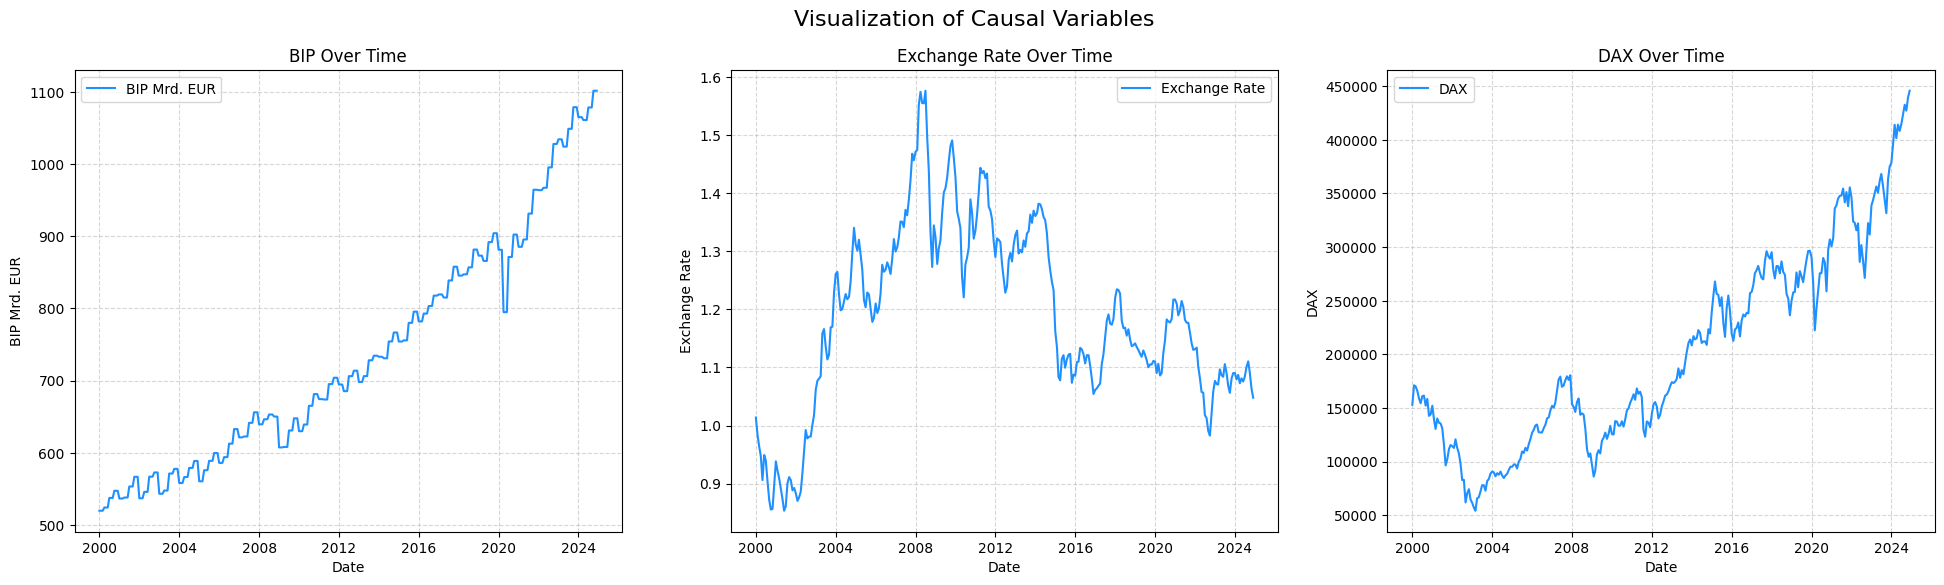

In [136]:
# Create a figure with three subplots in one row
fig, axes = plt.subplots(1, 3, figsize=(24, 6))

# Plot BIP over time
axes[0].plot(df['Date'], df['BIP Mrd. EUR'], label='BIP Mrd. EUR', color='dodgerblue')
axes[0].set_title('BIP Over Time')
axes[0].set_xlabel('Date')
axes[0].set_ylabel('BIP Mrd. EUR')
axes[0].grid(True, linestyle='--', alpha=0.5)
axes[0].legend()

# Plot exchange rate over time
axes[1].plot(df['Date'], df['Monthly_Avg_Exchange_Rate'], label='Exchange Rate', color='dodgerblue')
axes[1].set_title('Exchange Rate Over Time')
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Exchange Rate')
axes[1].grid(True, linestyle='--', alpha=0.5)
axes[1].legend()

# Plot DAX over time
axes[2].plot(df['Date'], df['DAX'], label='DAX', color='dodgerblue')
axes[2].set_title('DAX Over Time')
axes[2].set_xlabel('Date')
axes[2].set_ylabel('DAX')
axes[2].grid(True, linestyle='--', alpha=0.5)
axes[2].legend()

# Adjust layout
fig.suptitle('Visualization of Causal Variables', fontsize=16)
plt.show()

## Linear Regression

### Simple Linear Regression

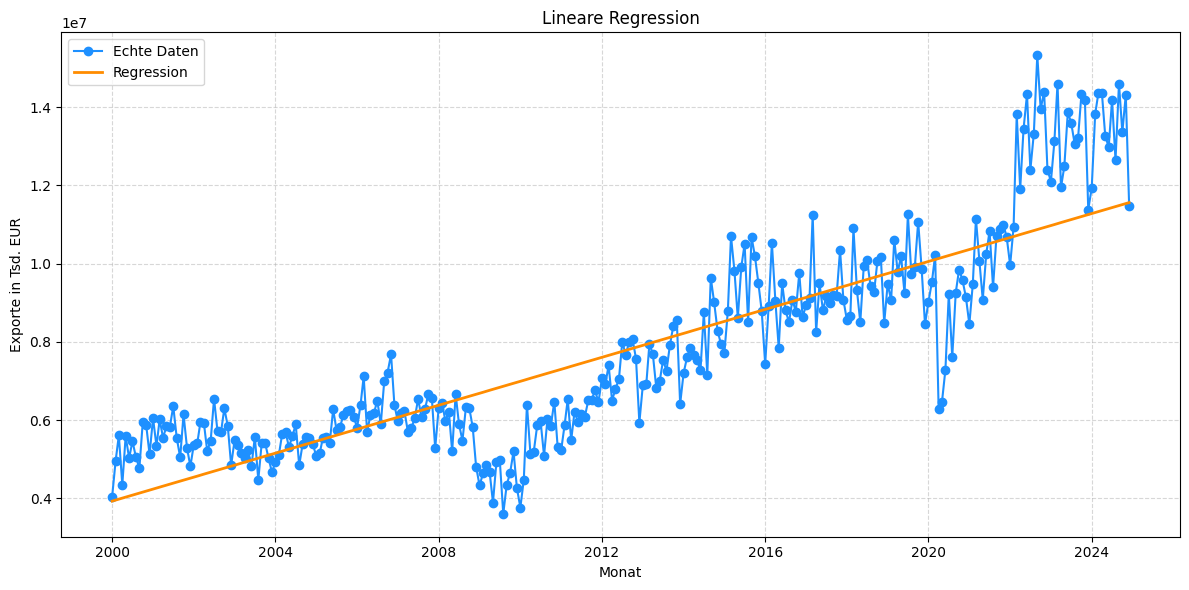

Mean Absolute Percentage Error (MAPE): 14.69%
Mean Absolute Deviation (MAD): 2037843.66
R^2: -4.2823


In [95]:


#Datensatz gessamt
X_all = df[['Monate_seit_start']]
y_all = df['value_Outgoing']

#Datensatz Training (Alle Monate bis auf die letzten 12)
X_train = df.iloc[:-12][['Monate_seit_start']]
y_train = df.iloc[:-12]['value_Outgoing']

#Datensatz Validierung (Letzten 12 Monate)
X_valid = df.iloc[-12:][['Monate_seit_start']]
y_valid = df.iloc[-12:]['value_Outgoing']

model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_all)

# Plot
plt.figure(figsize=(12, 6))
plt.plot(df['Date'], y_all, label='Echte Daten', marker='o', color='dodgerblue')
plt.plot(df['Date'], y_pred, label='Regression', color='darkorange', linewidth=2)
plt.xlabel('Monat')
plt.ylabel('Exporte in Tsd. EUR')
plt.title('Lineare Regression')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# Calculate Mean Absolute Percentage Error (MAPE) oonn the validation set
mape = np.mean(np.abs((y_valid - y_pred[-12:]) / y_valid)) * 100
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")

# Calculate Mean Absolute Deviation (MAD) on the validation set
mad = np.mean(np.abs(y_valid - y_pred[-12:]))
print(f"Mean Absolute Deviation (MAD): {mad:.2f}")
# Calculate R^2 (coefficient of determination) on the validation set
# Calculate R^2 (coefficient of determination) on the validation set
ss_total = np.sum((y_valid - np.mean(y_valid)) ** 2)
ss_residual = np.sum((y_valid - y_pred[-12:]) ** 2)
r_squared = 1 - (ss_residual / ss_total)
print(f"R^2: {r_squared:.4f}")

### Linear Regression Saison

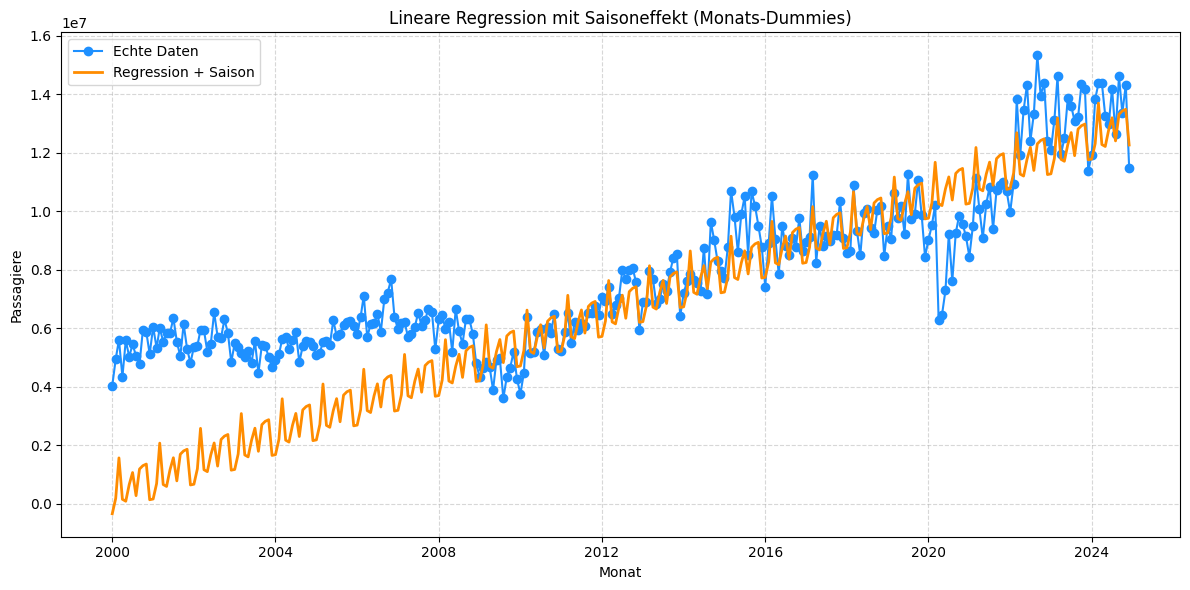

Mean Absolute Percentage Error (MAPE): 5.99%
Mean Absolute Deviation (MAD): 825041.45


In [96]:
df['Monat_num'] = df['Date'].dt.month
dummies = pd.get_dummies(df['Monat_num'], prefix='Monat', drop_first=True)  # Drop First = Referenzmonat

# Features zusammenstellen
X_all = pd.concat([df[['Monate_seit_start']], dummies], axis=1)
y_all = df['value_Outgoing']

# Split in Training (alles bis auf letzte 12 Monate) und Validierung (letzte 12 Monate)
X_train = X_all.iloc[:-12]
# Split in Training ud Validierung die ersten 120 Monate werden nicht verwendet
X_train = X_train[-180:]
y_train = y_all.iloc[:-12]
y_train = y_train[-180:]
X_valid = X_all.iloc[-12:]
y_valid = y_all.iloc[-12:]

# Modell trainieren
model = LinearRegression()
model.fit(X_train, y_train)

# Vorhersage über gesamten Zeitraum (für Plot) + Validierung
y_pred_all = model.predict(X_all)
y_pred_valid = model.predict(X_valid)

#print(y_pred_all[-12:])
#print(y_pred_valid)

# Plot
plt.figure(figsize=(12, 6))
plt.plot(df['Date'], y_all, label='Echte Daten', marker='o', color='dodgerblue')
plt.plot(df['Date'], y_pred_all, label='Regression + Saison', color='darkorange', linewidth=2)
plt.xlabel('Monat')
plt.ylabel('Passagiere')
plt.title('Lineare Regression mit Saisoneffekt (Monats-Dummies)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# Metriken auf dem Validierungsset
mape = np.mean(np.abs((y_valid - y_pred_valid) / y_valid)) * 100
mad = np.mean(np.abs(y_valid - y_pred_valid))

print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
print(f"Mean Absolute Deviation (MAD): {mad:.2f}")


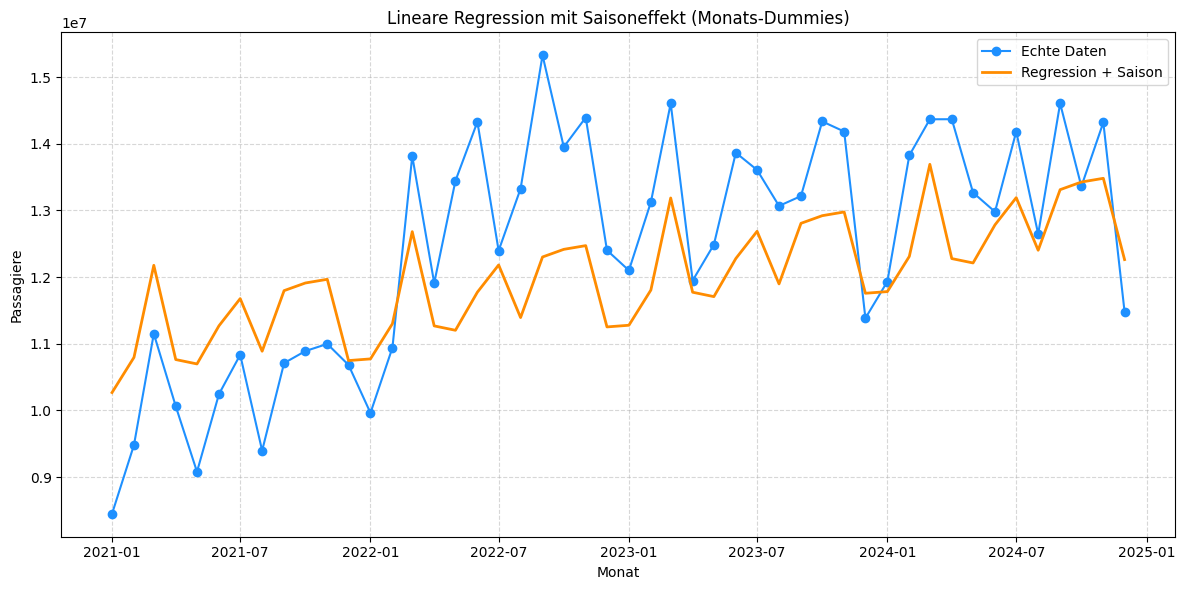

Mean Absolute Percentage Error (MAPE): 5.99%
Mean Absolute Deviation (MAD): 825041.45


In [104]:
df['Monat_num'] = df['Date'].dt.month
dummies = pd.get_dummies(df['Monat_num'], prefix='Monat', drop_first=True)  # Drop First = Referenzmonat

# Features zusammenstellen
X_all = pd.concat([df[['Monate_seit_start']], dummies], axis=1)
y_all = df['value_Outgoing']

# Split in Training (alles bis auf letzte 12 Monate) und Validierung (letzte 12 Monate)
X_train = X_all.iloc[:-12]
# Split in Training ud Validierung die ersten 120 Monate werden nicht verwendet
X_train = X_train.iloc[-180:]
y_train = y_all.iloc[:-12]
y_train = y_train.iloc[-180:]
X_valid = X_all.iloc[-12:]
y_valid = y_all.iloc[-12:]

# 180: Mape = 5.71

# Modell trainieren
model = LinearRegression()
model.fit(X_train, y_train)

# Vorhersage über gesamten Zeitraum (für Plot) + Validierung
y_pred_all = model.predict(X_all)
y_pred_valid = model.predict(X_valid)

#print(y_pred_all[-12:])
#print(y_pred_valid)

# Plot
plt.figure(figsize=(12, 6))
plt.plot(df['Date'].iloc[-48:], y_all[-48:], label='Echte Daten', marker='o', color='dodgerblue')
plt.plot(df['Date'].iloc[-48:], y_pred_all[-48:], label='Regression + Saison', color='darkorange', linewidth=2)
plt.xlabel('Monat')
plt.ylabel('Passagiere')
plt.title('Lineare Regression mit Saisoneffekt (Monats-Dummies)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# Metriken auf dem Validierungsset
mape = np.mean(np.abs((y_valid - y_pred_valid) / y_valid)) * 100
mad = np.mean(np.abs(y_valid - y_pred_valid))

print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
print(f"Mean Absolute Deviation (MAD): {mad:.2f}")


### Linear Regression with Seasonal and Kausal

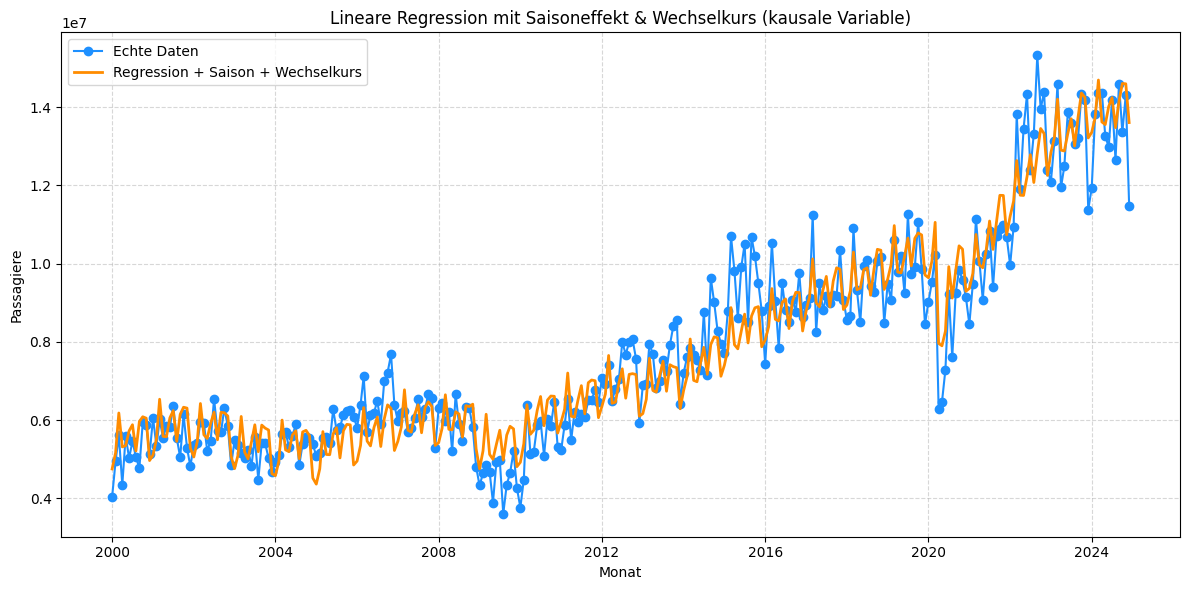

Mean Absolute Percentage Error (MAPE): 5.85%
Mean Absolute Deviation (MAD): 742808.96


In [ ]:
# Monat extrahieren und Dummies erzeugen
df['Monat_num'] = df['Date'].dt.month
dummies = pd.get_dummies(df['Monat_num'], prefix='Monat', drop_first=True)


# Kausale Variable: Wechselkurs (Exchange Rate)
kausale_variable = df[['Monthly_Avg_Exchange_Rate', 'BIP Mrd. EUR', 'DAX']]  # Falls du mehrere hast, hier einfach mehr auswählen
#Mit DAX -> Forecast besser, Finanzkrise nicht mehr so stark


# Features zusammenstellen
X_all = pd.concat([df[['Monate_seit_start']], dummies, kausale_variable], axis=1)
y_all = df['value_Outgoing']

# Training (letzte 180 von allen bis auf die letzten 12) & Validierung (letzte 12)
X_train = X_all.iloc[:-12]#.iloc[-180:]
y_train = y_all.iloc[:-12]#.iloc[-180:]
X_valid = X_all.iloc[-12:]
y_valid = y_all.iloc[-12:]

# Modell trainieren
model = LinearRegression()
model.fit(X_train, y_train)

# Vorhersagen
y_pred_all = model.predict(X_all)
y_pred_valid = model.predict(X_valid)

# Plot
plt.figure(figsize=(12, 6))
plt.plot(df['Date'], y_all, label='Echte Daten', marker='o', color='dodgerblue')
plt.plot(df['Date'], y_pred_all, label='Regression + Saison + Wechselkurs', color='darkorange', linewidth=2)
plt.xlabel('Monat')
plt.ylabel('Passagiere')
plt.title('Lineare Regression mit Saisoneffekt & Wechselkurs (kausale Variable)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# Metriken
mape = np.mean(np.abs((y_valid - y_pred_valid) / y_valid)) * 100
mad = np.mean(np.abs(y_valid - y_pred_valid))

print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
print(f"Mean Absolute Deviation (MAD): {mad:.2f}")


## Smoothing Methods

### Simple Exp Smoothing

### Double Exp Smoothing

### Triple Exp Smoothing (additiv)

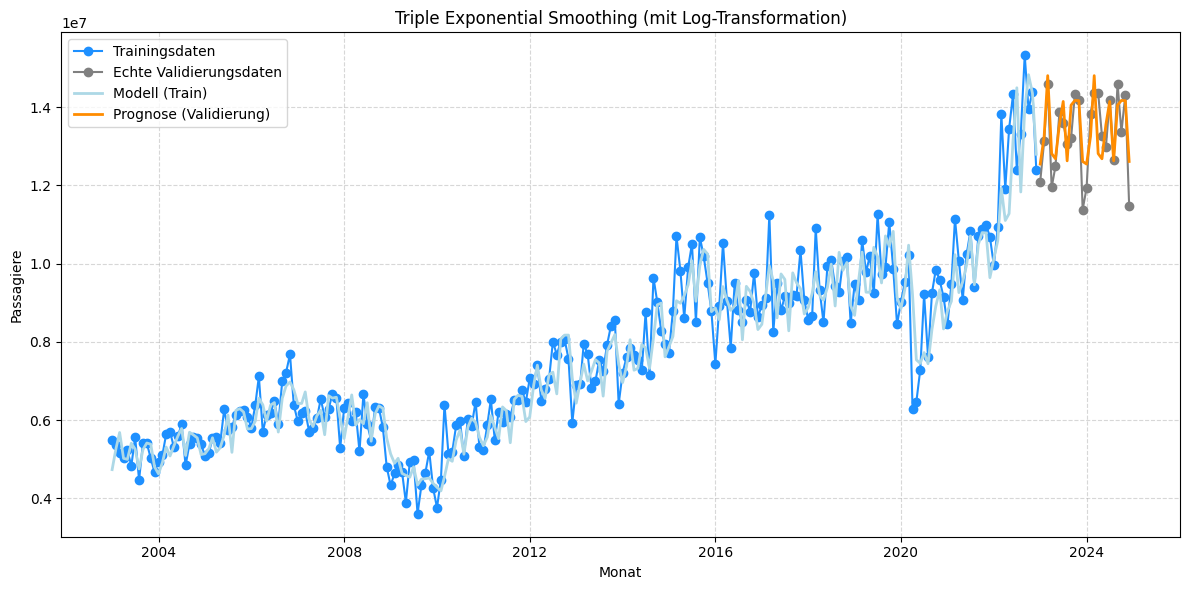

Mean Absolute Percentage Error (MAPE): 4.00%
Mean Absolute Deviation (MAD): 517,272
 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 1.6185007788950285
       x: [ 4.642e-01  6.135e-02]
     nit: 5
     jac: [ 2.275e-04  1.165e-03]
    nfev: 17
    njev: 5
{'smoothing_level': np.float64(0.4641736466822869), 'smoothing_trend': np.float64(nan), 'smoothing_seasonal': np.float64(0.06135162995689008), 'damping_trend': nan, 'initial_level': np.float64(15.431708109250767), 'initial_trend': np.float64(nan), 'initial_seasons': array([-0.06162093, -0.02079341,  0.04557075, -0.0322689 , -0.03857128,
        0.01904661,  0.04349292, -0.08421806,  0.0438489 ,  0.05931087,
        0.05411822, -0.02791569]), 'use_boxcox': False, 'lamda': None, 'remove_bias': False}
R^2: 0.5685


In [99]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Zielvariable + Log-Transformation
y_all = df['value_Outgoing']
y_all_log = np.log(y_all)  # Logarithmische Transformation

D_VALID = 24
D_TRAIN = 240

# Split
y_train_log = y_all_log.iloc[:-D_VALID].iloc[-D_TRAIN:]
y_valid_log = y_all_log.iloc[-D_VALID:]
dates_train = df['Date'].iloc[:-D_VALID].iloc[-D_TRAIN:]
dates_valid = df['Date'].iloc[-D_VALID:]

# Modell definieren (mit additiver Saison für log-Werte!)
model = ExponentialSmoothing(
    y_train_log,
    trend=None,  # Kein Trend hier — kannst auf 'add' setzen, falls sinnvoll
    seasonal='add',  # Achtung! Log-Transformation → 'add' für Saisonalität
    seasonal_periods=12,
    initialization_method="heuristic"  # Stabiler als 'estimated'
)

# Modell fitten
fit = model.fit()

# Vorhersagen (im Log-Raum)
y_pred_train_log = fit.fittedvalues
y_pred_valid_log = fit.forecast(D_VALID)

# Rücktransformation (Exponentiation)
y_train = np.exp(y_train_log)
y_valid = np.exp(y_valid_log)
y_pred_train = np.exp(y_pred_train_log)
y_pred_valid = np.exp(y_pred_valid_log)

# Plot
plt.figure(figsize=(12, 6))
plt.plot(dates_train, y_train, label='Trainingsdaten', color='dodgerblue', marker='o')
plt.plot(dates_valid, y_valid, label='Echte Validierungsdaten', color='grey', marker='o')
plt.plot(dates_train, y_pred_train, label='Modell (Train)', color='lightblue', linewidth=2)
plt.plot(dates_valid, y_pred_valid, label='Prognose (Validierung)', color='darkorange', linewidth=2)
plt.xlabel('Monat')
plt.ylabel('Passagiere')
plt.title('Triple Exponential Smoothing (mit Log-Transformation)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# Evaluation auf Originalskala
mape = np.mean(np.abs((y_valid - y_pred_valid) / y_valid)) * 100
mad = np.mean(np.abs(y_valid - y_pred_valid))

print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
print(f"Mean Absolute Deviation (MAD): {mad:,.0f}")

# Details zur Optimierung
print(fit.mle_retvals)
print(fit.params)

# Calculate R^2 (coefficient of determination)
ss_total = np.sum((y_valid - np.mean(y_valid)) ** 2)
ss_residual = np.sum((y_valid - y_pred_valid) ** 2)
r_squared = 1 - (ss_residual / ss_total)

print(f"R^2: {r_squared:.4f}")


### Triple Exp Smoothing (multiplicative)

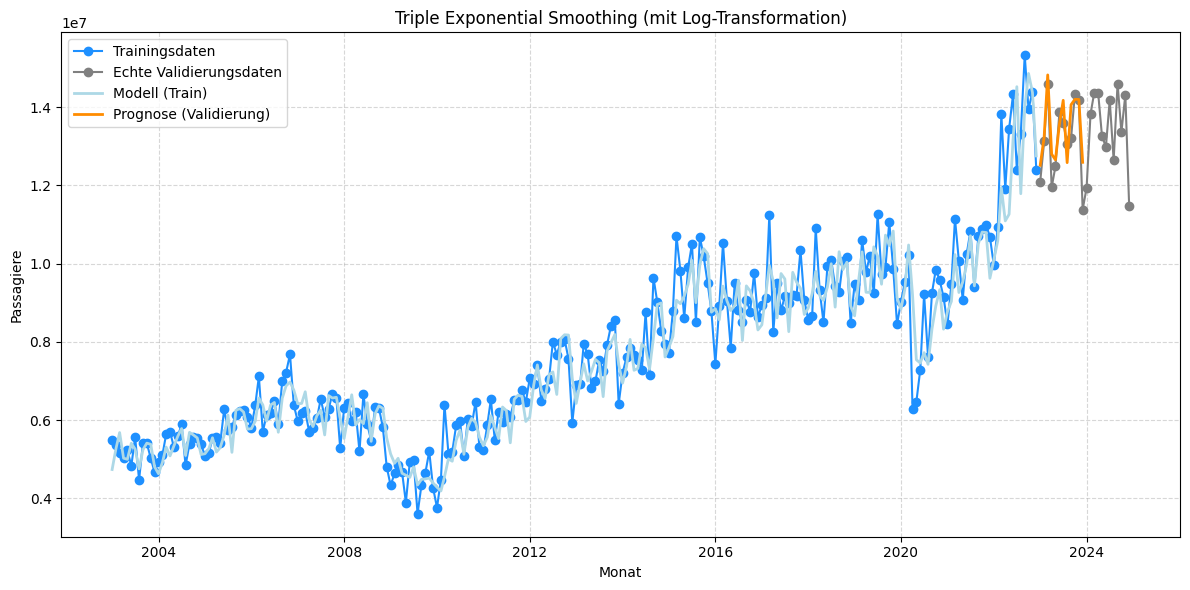

Mean Absolute Percentage Error (MAPE): 3.53%
Mean Absolute Deviation (MAD): 444,075
 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 1.619435230042162
       x: [ 4.631e-01  5.897e-02]
     nit: 5
     jac: [ 1.472e-05  2.919e-05]
    nfev: 17
    njev: 5
{'smoothing_level': np.float64(0.4630781166741934), 'smoothing_trend': np.float64(nan), 'smoothing_seasonal': np.float64(0.05897451345340359), 'damping_trend': nan, 'initial_level': np.float64(15.431708109250767), 'initial_trend': np.float64(nan), 'initial_seasons': array([0.99604124, 0.99865906, 1.0029251 , 0.99795181, 0.99753166,
       1.00123363, 1.00281075, 0.99457705, 1.00281528, 1.00380495,
       1.00345486, 0.99819461]), 'use_boxcox': False, 'lamda': None, 'remove_bias': False}
R^2: 0.8366


In [135]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Zielvariable + Log-Transformation
y_all = df['value_Outgoing']
y_all_log = np.log(y_all)  # Logarithmische Transformation

D_VALID = 24
D_TRAIN = 240

# Split
y_train_log = y_all_log.iloc[:-D_VALID].iloc[-D_TRAIN:]
y_valid_log = y_all_log.iloc[-D_VALID:]
dates_train = df['Date'].iloc[:-D_VALID].iloc[-D_TRAIN:]
dates_valid = df['Date'].iloc[-D_VALID:]

# Modell definieren (mit additiver Saison für log-Werte!)
model = ExponentialSmoothing(
    y_train_log,
    trend=None,  # Kein Trend hier — kannst auf 'add' setzen, falls sinnvoll
    seasonal='multiplicative',  # Achtung! Log-Transformation → 'add' für Saisonalität
    seasonal_periods=12,
    initialization_method="heuristic"  # Stabiler als 'estimated'
)

# Modell fitten
fit = model.fit()

# Vorhersagen (im Log-Raum)
y_pred_train_log = fit.fittedvalues
y_pred_valid_log = fit.forecast(12)

# Rücktransformation (Exponentiation)
y_train = np.exp(y_train_log)
y_valid = np.exp(y_valid_log)
y_pred_train = np.exp(y_pred_train_log)
y_pred_valid = np.exp(y_pred_valid_log)

# Plot
plt.figure(figsize=(12, 6))
plt.plot(dates_train, y_train, label='Trainingsdaten', color='dodgerblue', marker='o')
plt.plot(dates_valid, y_valid, label='Echte Validierungsdaten', color='grey', marker='o')
plt.plot(dates_train, y_pred_train, label='Modell (Train)', color='lightblue', linewidth=2)
plt.plot(dates_valid[:-12], y_pred_valid, label='Prognose (Validierung)', color='darkorange', linewidth=2)
plt.xlabel('Monat')
plt.ylabel('Passagiere')
plt.title('Triple Exponential Smoothing (mit Log-Transformation)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# Evaluation auf Originalskala
mape = np.mean(np.abs((y_valid - y_pred_valid) / y_valid)) * 100
mad = np.mean(np.abs(y_valid - y_pred_valid))

print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
print(f"Mean Absolute Deviation (MAD): {mad:,.0f}")

# Details zur Optimierung
print(fit.mle_retvals)
print(fit.params)

# Calculate R^2 (coefficient of determination)
ss_total = np.sum((y_valid - np.mean(y_valid)) ** 2)
ss_residual = np.sum((y_valid - y_pred_valid) ** 2)
r_squared = 1 - (ss_residual / ss_total)

print(f"R^2: {r_squared:.4f}")


## Arima Models

### ACF-Plot

<Figure size 1000x400 with 0 Axes>

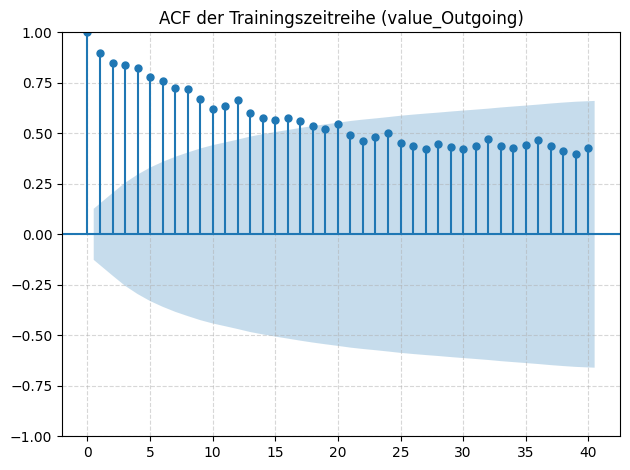

In [101]:
from statsmodels.graphics.tsaplots import plot_acf

plt.figure(figsize=(10, 4))
plot_acf(y_train, lags=40, alpha=0.05)
plt.title('ACF der Trainingszeitreihe (value_Outgoing)')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

### PACF-PLot

<Figure size 1000x400 with 0 Axes>

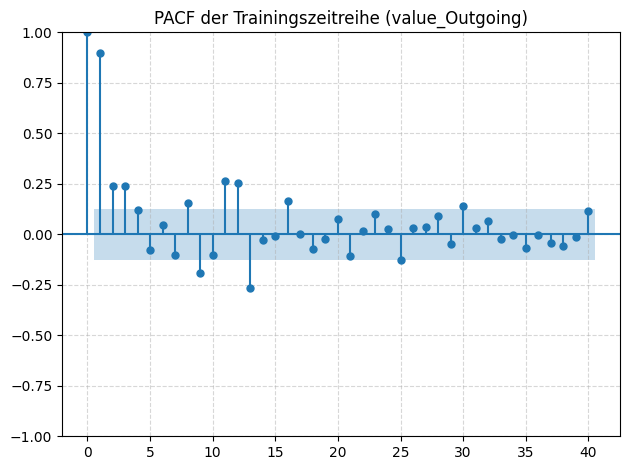

In [102]:
from statsmodels.graphics.tsaplots import plot_pacf

plt.figure(figsize=(10, 4))
plot_pacf(y_train, lags=40, method='ywm', alpha=0.05)
plt.title('PACF der Trainingszeitreihe (value_Outgoing)')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

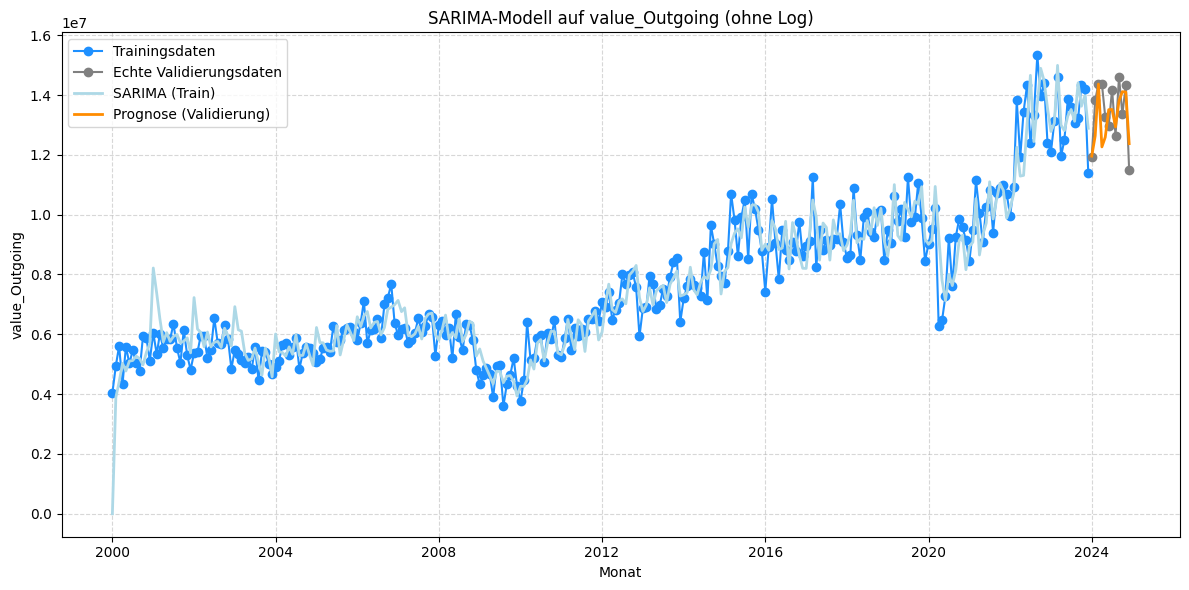

Mean Absolute Percentage Error (MAPE): 5.01%
Mean Absolute Deviation (MAD): 679,402
                                     SARIMAX Results                                      
Dep. Variable:                     value_Outgoing   No. Observations:                  288
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -3885.096
Date:                            Thu, 01 May 2025   AIC                           7780.191
Time:                                    13:23:04   BIC                           7798.014
Sample:                                         0   HQIC                          7787.355
                                            - 288                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1120      0.1

In [103]:
from statsmodels.tsa.statespace.sarimax import SARIMAX


# Zielvariable
y_all = df['value_Outgoing']

# Trainings- und Validierungsdaten
D_VALID = 12
y_train = y_all.iloc[:-D_VALID]
y_valid = y_all.iloc[-D_VALID:]
dates_train = df['Date'].iloc[:-D_VALID]
dates_valid = df['Date'].iloc[-D_VALID:]

# SARIMA-Modell definieren
model = SARIMAX(
    y_train,
    order=(1, 1, 1),
    seasonal_order=(1, 1, 1, 12),
    enforce_stationarity=False,
    enforce_invertibility=False
)

# Modell fitten
fit = model.fit(disp=False)

# Vorhersagen
y_pred_train = fit.fittedvalues
y_pred_valid = fit.forecast(steps=D_VALID)

# Plot
plt.figure(figsize=(12, 6))
plt.plot(dates_train, y_train, label='Trainingsdaten', color='dodgerblue', marker='o')
plt.plot(dates_valid, y_valid, label='Echte Validierungsdaten', color='grey', marker='o')
plt.plot(dates_train, y_pred_train, label='SARIMA (Train)', color='lightblue', linewidth=2)
plt.plot(dates_valid, y_pred_valid, label='Prognose (Validierung)', color='darkorange', linewidth=2)
plt.xlabel('Monat')
plt.ylabel('value_Outgoing')
plt.title('SARIMA-Modell auf value_Outgoing (ohne Log)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# Evaluation
mape = np.mean(np.abs((y_valid - y_pred_valid) / y_valid)) * 100
mad = np.mean(np.abs(y_valid - y_pred_valid))

print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
print(f"Mean Absolute Deviation (MAD): {mad:,.0f}")

# Modellzusammenfassung
print(fit.summary())

ss_total = np.sum((y_valid - np.mean(y_valid)) ** 2)
ss_residual = np.sum((y_valid - y_pred_valid) ** 2)
r_squared = 1 - (ss_residual / ss_total)

print(f"R^2: {r_squared:.4f}")
